In [5]:
##https://www.statology.org/matplotlib-rectangle/
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import girder_client
import dsaSecrets 
import random
from matplotlib.patches import Rectangle
%load_ext autoreload
%autoreload 2


import tmaHelpers as tma

gc = girder_client.GirderClient(apiUrl=dsaSecrets.apiUrl)
gc.authenticate(apiKey=dsaSecrets.apiToken)
## Samples Images 62bb03e4e70def4ae72689f5

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## SEt all the variables needed to pull an image, as well as the fiducial points.. for now the fiducials are at 0.625X

imgId = '62bb03e4e70def4ae72689f5'
dispMag = 0.625 ### For testing I don't want to try and view the entire 20 or 40X image..

#add rectangle
topLeft = (115,50)
bottomRight = (1540,1180)
topRight = (1560,70)

colLabels = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O"]
rowLabels = [1,2,3,4,5,6,7,8,9,10]


tileInfo = gc.get('item/%s/tiles' % imgId)
#https://styx.neurology.emory.edu/girder/api/v1/item/62bb03e4e70def4ae72689f5/tiles/region?units=base_pixels&magnification=0.625&exact=false&encoding=JPEG&jpegQuality=95&jpegSubsampling=0
imgThumb = gc.get("item/%s/tiles/region?units=base_pixel&magnification=%s" % (imgId, dispMag),jsonResp=False)

In [3]:
## Convert image to a numpy array so I can plot it with matplotlib
region_im = np.array(Image.open(BytesIO(imgThumb.content)))


{'_accessLevel': 2,
 '_id': '62c85d12e70def4ae72693ea',
 '_modelType': 'annotation',
 '_version': 491834,
 'annotation': {'description': 'This is a description',
  'elements': [{'center': [5200.0, 3408.0, 0],
    'fillColor': 'rgba(0, 0, 0, 0)',
    'height': 3616.0,
    'id': '62c85d12e70def4ae72693eb',
    'label': {'value': 'A1'},
    'lineColor': 'rgb(232,245,139)',
    'lineWidth': 1,
    'type': 'rectangle',
    'width': 3040.0},
   {'center': [5200.0, 7024.0, 0],
    'fillColor': 'rgba(0, 0, 0, 0)',
    'height': 3616.0,
    'id': '62c85d12e70def4ae72693ec',
    'label': {'value': 'A2'},
    'lineColor': 'rgb(150,48,41)',
    'lineWidth': 1,
    'type': 'rectangle',
    'width': 3040.0},
   {'center': [5200.0, 10640.0, 0],
    'fillColor': 'rgba(0, 0, 0, 0)',
    'height': 3616.0,
    'id': '62c85d12e70def4ae72693ed',
    'label': {'value': 'A3'},
    'lineColor': 'rgb(92,214,25)',
    'lineWidth': 1,
    'type': 'rectangle',
    'width': 3040.0},
   {'center': [5200.0, 14256.0,

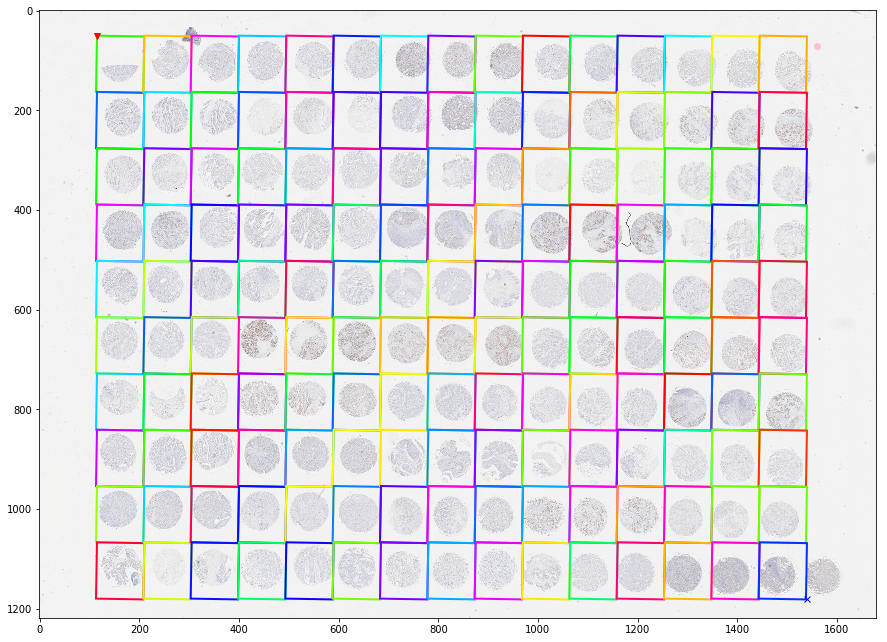

In [14]:
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(region_im)

tmaWidth = ( bottomRight[0] - topLeft[0] ) / len(colLabels)
tmaHeight = ( bottomRight[1] - topLeft[1] ) / len(rowLabels)



elementScaleFactor = tileInfo['magnification']/dispMag

cmap = tma.get_cmap( len(colLabels) * len(rowLabels))

## While I display the ROI in a matplotlib figure below
annotationElements = []

for x,r in enumerate(colLabels):
    #print("Row: %s" % r)
    for y,c in enumerate(rowLabels):
        #print("\t",r,c)

        x1 = tmaWidth*x+topLeft[0]
        y1 = tmaHeight*y+topLeft[1]
        
        plt.gca().add_patch(Rectangle((x1,y1),tmaWidth,tmaHeight,
                            angle=1,
                            edgecolor=cmap( random.randint(0,len(colLabels) * len(rowLabels))),
                            facecolor='none',
                            lw=2))
        
        annotationElements.append( {'fillColor': 'rgba(0, 0, 0, 0)',
    'label': {"value": "%s%s" % (r,c)},
    'lineColor': tma.generate_random_color(),
    'lineWidth': 1,
    'type': 'rectangle',
    'center': [(x1+tmaWidth/2)*elementScaleFactor,(y1+tmaHeight/2)*elementScaleFactor,0],
    'width': tmaWidth*elementScaleFactor,
    'height': tmaHeight*elementScaleFactor,
    })
        
#plot fiducial for upper left 
plt.plot(topLeft[0],topLeft[1], marker='v', color="red")
#plot fiducial for bottom right
plt.plot(bottomRight[0],bottomRight[1], marker='x', color="blue")

#add fiducial for topRight
plt.plot(topRight[0],topRight[1], marker='o', color="pink")

tmaAe = {
  "name": "autoTMA",              # Non-empty string.  Optional
  "description": "This is a description",  # String.  Optional
  "elements": annotationElements                           # A list.  Optional.
                                           # See below for valid elements.
}
gc.post('annotation?itemId=%s' % imgId,json=tmaAe)


In [53]:
from IPython.display import display
import matplotlib.pylab as plt
import numpy as np
from ipywidgets import interact,FloatSlider,IntSlider,interactive,HBox
%matplotlib inline
def plotPP(p,p_LP,Tperiods):
    t=np.linspace(0,Tperiods*(np.pi*2),1000)
    f = plt.figure(figsize=(1.618*6,6))
    p_t = p*(1.0+np.cos(t))
    plt.plot(t,p_t,'b',lw=2.0)
    plt.axhline(p_LP,color='r',lw=2.0)
    plt.xlim([t[0],t[-1]])
    plt.ylim([min(p_LP,np.amin(p_t))-0.1,np.amax(p_t)+0.1])
    plt.ylabel(r'$p$')
    plt.xlabel(r'$t$')

p_s       = FloatSlider(min=0, max=2, step=0.01, value=1.0)
p_LP_s    = FloatSlider(min=0, max=2., step=0.01, value=0.481343)
Tperiods_s= IntSlider(min=1,max=10,value=1)

ip = interactive(plotPP,p=p_s,p_LP=p_LP_s,Tperiods=Tperiods_s)
display(HBox(ip.children[:-1]))#Show all controls
display(ip.children[-1])#Show the output

Output()

210 163 95 113


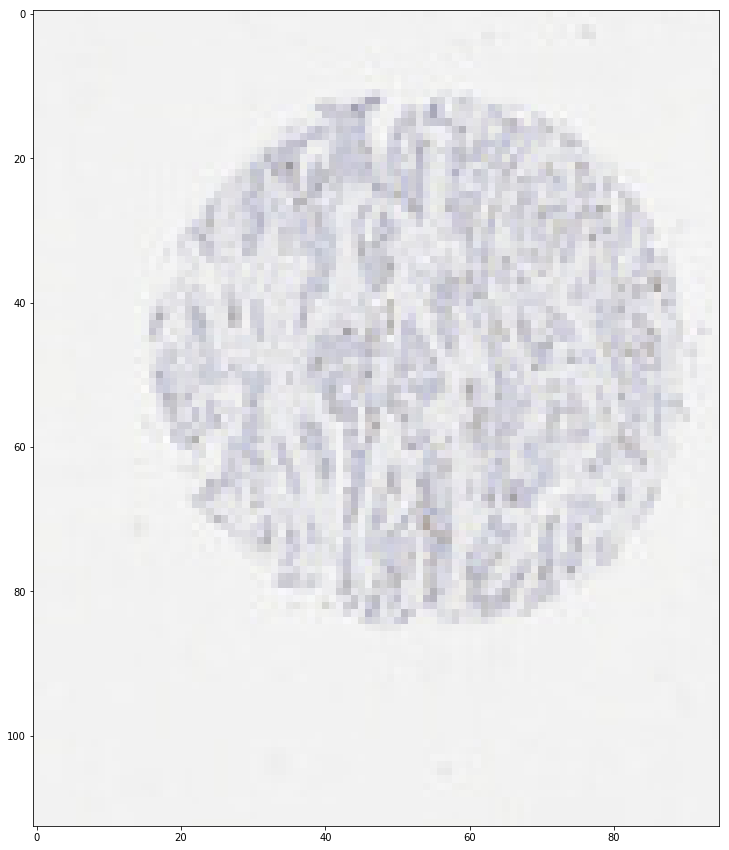

In [52]:
x=1
y=1
x1 = int(tmaWidth*x+topLeft[0])
y1 = int(tmaHeight*y+topLeft[1])
w =  int(tmaWidth)
h = int(tmaHeight)
print(x1,y1,w,h)
plt.imshow(region_im[y1:(y1+h),x1:(x1+w),:])

tmaCore = region_im[y1:(y1+h),x1:(x1+w),:]

### Rotating a grid...  need to also deal with offset..
X=xcos(θ)+ysin(θ)
Y=−x*sin(θ)+y*cos(θ)


In [42]:
region_im.shape
# tmaAe
# # for x,r in enumerate(rowLabels):
# #     print("Row: %s" % r)
# #     for y,c in enumerate(colLabels):
# #         print("\t",r,c)a

(1219, 1680, 3)

In [15]:
#### Need to now generate code to push the ROI (that's scaled as well!!! ) to the base image...
### I will call the basic document autoTMA
### First get the annotations info... this doesn't contain the actual shapes though
## was TMAGrid
a = gc.get('annotation?itemId=%s&text=autoTMA' % imgId)
## Now get the actual annotation document..
d =  gc.get('annotation/%s' % a[0]['_id'])
d

{'_accessLevel': 2,
 '_id': '62c85d12e70def4ae72693ea',
 '_modelType': 'annotation',
 '_version': 491834,
 'annotation': {'description': 'This is a description',
  'elements': [{'fillColor': 'rgba(0, 0, 0, 0)',
    'label': {'value': 'A1'},
    'lineColor': 'rgb(232,245,139)',
    'lineWidth': 1,
    'type': 'rectangle',
    'center': [5200.0, 3408.0, 0],
    'width': 3040.0,
    'height': 3616.0,
    'id': '62c85d12e70def4ae72693eb'},
   {'fillColor': 'rgba(0, 0, 0, 0)',
    'label': {'value': 'A2'},
    'lineColor': 'rgb(150,48,41)',
    'lineWidth': 1,
    'type': 'rectangle',
    'center': [5200.0, 7024.0, 0],
    'width': 3040.0,
    'height': 3616.0,
    'id': '62c85d12e70def4ae72693ec'},
   {'fillColor': 'rgba(0, 0, 0, 0)',
    'label': {'value': 'A3'},
    'lineColor': 'rgb(92,214,25)',
    'lineWidth': 1,
    'type': 'rectangle',
    'center': [5200.0, 10640.0, 0],
    'width': 3040.0,
    'height': 3616.0,
    'id': '62c85d12e70def4ae72693ed'},
   {'fillColor': 'rgba(0, 0, 0,

In [37]:
### Try and download the first roi..

ae = d['annotation']['elements'][1]

In [38]:
r= tma.get_annotation_region(gc,imgId,ae)

{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'A2'}, 'lineColor': 'rgb(150,48,41)', 'lineWidth': 1, 'type': 'rectangle', 'center': [5200.0, 7024.0, 0], 'width': 3040.0, 'height': 3616.0, 'id': '62c85d12e70def4ae72693ec'}
62bb03e4e70def4ae72689f5/tiles/region?left=3680.0&top=5216.0&right=6720.0&bottom=8832.0&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0


In [39]:
imgLocalFileName = 'imabig2.tiff'

with open(imgLocalFileName,"wb") as fpi:
    fpi.write(r)


47 56


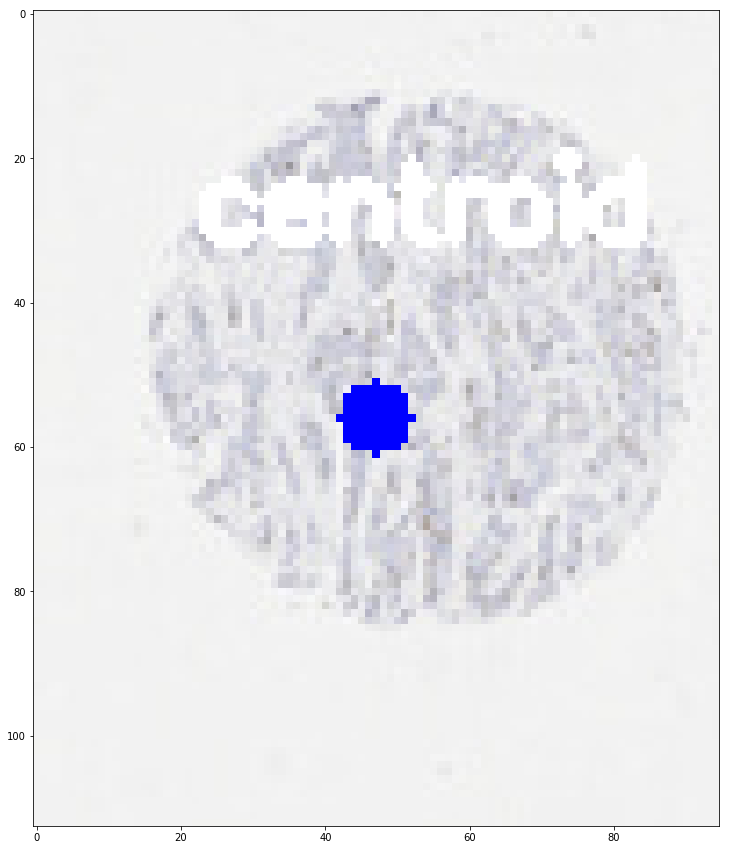

In [68]:
import cv2
img = tmaCore

gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # convert the grayscale image to binary image
ret,thresh = cv2.threshold(gray_image,127,255,0)

# # calculate moments of binary image
M = cv2.moments(thresh)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
# # put text and highlight the center
# 15
cv2.circle(img, (cX, cY), 5, (0, 0, 255), -1)
# 16
cv2.putText(img, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
# 17
print(cX,cY)
# 18
# # display the image
# 19
# cv2.imshow("Image", img)
# 20
# cv2.waitKey(0)
plt.imshow(img)

In [64]:
img.shape

(113, 95, 3)